In [ ]:
from tool import *
warnings.filterwarnings("ignore")


# albedo

In [ ]:

fs=glob('/data/hk/albedo/landcover/2*/*-*')
for f in fs:
    os.remove(f)

In [ ]:
#检查文件像元大小
for y,m in[[2001,1],[2020,1]]:
    print('*'*20,y,m,'*'*20)
    # /data/hk/albedo/albedo/2020_1_albedo/
    fs=glob(f'/data/hk/albedo/albedo/{y}_{m}_albedo/{y}_{m}-*.tif')
    print(len(fs))
    for f in fs:
        ds=gdal.Open(f)
        if ds.GetGeoTransform()[1]!=0.004491576420597608:
            print(f)

In [ ]:
#拼接
#run splice.py
y=2001
m=2
print(y,m)
fs=glob(f'/data/hk/albedo/{y}_{m}_albedo2/{y}_{m}*.tif')
for i in range(1,15):
    print('-'*20,i,'-'*20)
    time.sleep(1)
    splice(fs,f'/data/hk/albedo/{y}_{m}_albedo2/{y}_{m}_band{i}.tif',pixel_size=0.004491576420597608,band_num=i,type='int32')

In [ ]:
#删除原文件
for y,m in[[2001,2],[2001,3],[2001,4],[2001,5],[2001,6],[2020,2],[2020,3],[2020,4],[2020,5],[2020,6]]:
    print('*'*20,y,m,'*'*20)
    fs=glob(f'/data/hk/albedo/{y}_{m}_albedo2/{y}_{m}-*.tif')
    for f in fs:
        os.remove(f)

In [ ]:
#可视化检查
for y,m in[[2001,2],[2001,3],[2001,4],[2001,5],[2001,6],[2020,2],[2020,3],[2020,4],[2020,5],[2020,6]]:
    print('*'*20,y,m,'*'*20)
    img=get_img(y,m,'BSA_vis_snow',coord=None,path=None)
    plt.imshow(img)
    plt.colorbar()
    plt.show()

# landcover

In [ ]:
#修改landcover
from tool import *
def tif_save(img,save_name,trf,p='4326'):
    driver=gdal.GetDriverByName('GTiff')
    new_img=driver.Create(save_name,img.shape[1],img.shape[0],1,1,['COMPRESS=LZW','BIGTIFF=YES'])
    new_img.SetGeoTransform(trf)
    
    if p=='4326':
        sref = osr.SpatialReference()
        sref.ImportFromEPSG(4326)
        proj = sref.ExportToWkt()
    else:
        proj=p
    new_img.SetProjection(proj)
    new_img.GetRasterBand(1).SetNoDataValue(0)
    new_img.GetRasterBand(1).WriteArray(img)
    new_img.FlushCache()
    del new_img
ys=[os.path.basename(i).split('_')[0] for i in glob(root_path+f"landcover/*_landcover/*_landcover.tif")]
ys.sort()
for y in ys:
    print(y)
    img=get_img(y,1,'landcover')
    img[31000:34000,70000:]=20
    path=root_path+f"landcover/{y}_landcover/{y}_landcover.tif"
    tif_save(img,path,global_trf)

for y in [2001,2003,2004,2005,2006,2007,2008,2009,2020]:
    path=f"/data/hk/albedo/landcover/{y}_landcover/{y}_landcover.tif"
    ds=gdal.Open(path)
    print(ds.GetGeoTransform())
    img=ds.ReadAsArray()
    print(img.shape)
    img[img==0]=20
    if y==2003:
        plt.imshow(img)
        plt.colorbar()
        plt.show()
    tif_save(img,path,global_trf,p='4326')

In [ ]:
# #计算每个grid的land面积
# for y in [2001,2003,2004,2005,2006,2007,2008,2009,2020]:
#     print(y)
#     time.sleep(1)
#     result={}
#     for lat in tqdm(range(90,-90,-1)):
#         for lon in range(-180,180):
#             result[str(lat)+','+str(lon)]=get_land_area(y,[lon,lat])
#     torch.save(result,f"/data/hk/albedo/landcover/{y}_landcover/{y}_landarea.pth")

# snow

In [ ]:
#月合成
for y in range(2011,2021):
    for m in range(1,13):
        _=monthly_snow_cover(y,m,True)


In [ ]:
#临近年依次fill nodata
for y in range(2001,2021):
    for m in range(1,13):
        fill_snow_cover(y,m,True)

In [ ]:
#临近月fill nodata
for y in range(2001,2021):
    for m in range(1,13):
        fill_snow_cover2(y,m)

In [ ]:
#IDW填充+平滑+重采样
from tool import *
for y in range(2011,2021):
    for m in range(1,13):
        c=str(y)+str(m).zfill(2)
        pp=f'/data/hk/albedo/snow/snow_monthly/{c}_fill2.npy'
        # print(pp)
        img=np.load(pp)

        for j in range(1):
            img[np.isnan(img)]=255
            img=img.astype(np.uint8)
            need_interp=(img==255)[24*100:-24*100].sum()
            print(need_interp)
            if need_interp!=0:
                # print(need_interp)
                out = fill.fillnodata(img, (img!=255),max_search_distance=20,smoothing_iterations=1)
                need_interp=(out==255)[24*100:-24*100].sum()
                if need_interp!=0:
                    
                    print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
                    print(need_interp)
            else:
                break
        resample(out,pp.replace('_fill2.npy','.tif'))

# white/black sky

In [10]:
from tool import *
black_nir=get_wb_fraction_data('nbd')
white_nir=get_wb_fraction_data('ndd')
black_vis=get_wb_fraction_data('vbd')
white_vis=get_wb_fraction_data('vdd')
fn=white_nir[0]/(white_nir[0]+black_nir[0])
fv=white_vis[0]/(white_vis[0]+black_vis[0])
f_white=(white_nir[0]+white_vis[0])/(white_nir[0]+black_nir[0]+white_vis[0]+black_vis[0])
f_white_data=f_white.data
f_white_mask=f_white.mask
f_white_data[f_white_mask==1]=2
f_white_data[f_white_mask==1]=2
ds=[resample_wb_fraction(f_white_data[i]) for i in range(240)]
f_white_resample=np.stack(ds)
f_white_resample[f_white_resample==2]=np.nan
torch.save(f_white_resample,root_path+'white_sky_fraction/white_sky_fraction.pth')

In [5]:
from tool import *
black_nir=get_wb_fraction_data('nbd')
white_nir=get_wb_fraction_data('ndd')
black_vis=get_wb_fraction_data('vbd')
white_vis=get_wb_fraction_data('vdd')
fn=white_nir[0]/(white_nir[0]+black_nir[0])
fv=white_vis[0]/(white_vis[0]+black_vis[0])

fn_white_data=fn.data
fn_white_mask=fn.mask
fn_white_data[fn_white_mask==1]=2
fn_white_data[fn_white_mask==1]=2

ds=[resample_wb_fraction(fn_white_data[i]) for i in range(240)]
fn_white_resample=np.stack(ds)
fn_white_resample[fn_white_resample==2]=np.nan
torch.save(fn_white_resample,root_path+'white_sky_fraction/white_sky_fraction_nir.pth')

fv_white_data=fv.data
fv_white_mask=fv.mask
fv_white_data[fv_white_mask==1]=2
fv_white_data[fv_white_mask==1]=2

ds=[resample_wb_fraction(fv_white_data[i]) for i in range(240)]
fv_white_resample=np.stack(ds)
fv_white_resample[fv_white_resample==2]=np.nan
torch.save(fv_white_resample,root_path+'white_sky_fraction/white_sky_fraction_vis.pth')

In [ ]:
from tool import *
black_nir=get_wb_fraction_data('nbd')
white_nir=get_wb_fraction_data('ndd')
black_vis=get_wb_fraction_data('vbd')
white_vis=get_wb_fraction_data('vdd')
fn=white_nir[0]/(white_nir[0]+black_nir[0])
fv=white_vis[0]/(white_vis[0]+black_vis[0])
f_white=(fn+fv)/2
f_white_data=f_white.data
f_white_mask=f_white.mask
f_white_data[f_white_mask==1]=2
f_white_data[f_white_mask==1]=2
ds=[resample_wb_fraction(f_white_data[i]) for i in range(240)]
f_white_resample=np.stack(ds)
f_white_resample[f_white_resample==2]=np.nan
torch.save(f_white_resample,root_path+'white_sky_fraction/white_sky_fraction.pth')

# SW

In [ ]:
from tool import *
for y in [2018,2019,2020]:
    for m in range(1,13):
        ds=gdal.Open(f"/data/hk/albedo/SW_MERRA2/{y}_{m}_SW.tif")
        ds.GetGeoTransform()
        img=ds.ReadAsArray()
        img2=np.mean(img.reshape(180,10,360,10).transpose(0,2,1,3).reshape(180,360,-1),axis=-1)
        torch.save(img2,f"/data/hk/albedo/SW_MERRA2/{y}_{m}_SW_1degree.tif")

In [27]:
for m in range(1,13):
    yy=[]
    for y in range(2001,2021):
        yy.append(torch.load(f"/data/hk/albedo/SW_MERRA2/{y}_{m}_SW_1degree.tif"))
    yy=np.mean(np.stack(yy),axis=0)
    torch.save(yy,f"/data/hk/albedo/SW_MERRA2/{m}_SW_1degree.tif")

# grid albedo

In [ ]:
from tool import *
warnings.filterwarnings("ignore")

In [ ]:
cc=get_10lat_information(2001,1,50)
cc.get_10lat_information()

In [ ]:
#合并
from tool import *
fs=glob(root_path+'information/*.pth')
ys=list(set([os.path.basename(i).split('_')[1] for i in fs]))
ys.sort()

print(ys[:-1])
ys=['2004','2014','2015','2016','2017','2018']
for y in ys:
    for m in tqdm(range(1,13),desc=f' {y} '):
        fs_y=glob(root_path+f'information/result3_{y}_{m}_*0.pth')
        if len(fs_y)!=18:
            raise(f'ERROR {len(fs_y)}')
        k={}
        for i in range(len(fs_y)):
            k.update(torch.load(fs_y[i]))
        torch.save(k,root_path+f'information2/result3_{y}_{m}_all.pth')

In [ ]:
from tool import *
for month in range(1,13):
    convert_to_nc(month)

In [ ]:
#fill albedo
from tool import *
bands=['albedo_BSA_vis', 
'albedo_WSA_vis', 
'albedo_BSA_nir', 
'albedo_WSA_nir', 
'albedo_BSA_shortwave',
'albedo_WSA_shortwave']
# landtypes=['landtype'+str(i) for i in range(1,18)]+['snow']
landtypes=['ocean']
for month in range(2,12):
    NC=nc.Dataset(root_path+f'information_fill/month_{month}.nc','r+')
    for type in landtypes:
        v_fill,dws=fill_albedo(month,type)
        NC.createVariable(f'DWS-{type}', 'f4', ("time", "latitude", "longitude"))
        NC.variables[f'DWS-{type}'][:]=dws
        for band_i in range(len(bands)):
            NC.variables[f'{bands[band_i]}-{type}'][:]=v_fill[band_i]
    NC.close()


# Confuse Matrix

In [ ]:
get_10lat_confusionmatrix(y,m,40)

# visiable

In [ ]:
#短波辐射年际变化
z=[]
for y in range(2001,2021):
    zz=0
    for m in range(1,13):
        zz+=torch.load(f"/data/hk/albedo/SW_MERRA2/{y}_{m}_SW_1degree.tif").sum()
    z.append(zz)
plt.plot(z)
    
        
    

In [18]:
#单位是1
from tool import *
WB_sky_fraction=torch.load("/data/hk/albedo/white_sky_fraction/white_sky_fraction.pth")
landtypes=['landtype'+str(i) for i in range(1,18)]+['snow']
stat={}
for month in range(1,13):
    NC=nc.Dataset(root_path+f'information_fill/month_{month}.nc','r')
    for year in range(2001,2021):
        types_stat=[]
        types_stat_albedo=[]
        sw=torch.load(f"/data/hk/albedo/SW_MERRA2/{month}_SW_1degree.tif")
        for type in landtypes:
            now=datetime.datetime.strptime(f'2001-{month}-1', '%Y-%m-%d')
            month_time=(now+relativedelta(months=1)-now).total_seconds()
            bs=NC.variables[f'albedo_BSA_shortwave-{type}'][year-2001]
            ws=NC.variables[f'albedo_WSA_shortwave-{type}'][year-2001]
            area_type=NC.variables[f'area-{type}'][year-2001] 
            area_land=NC.variables[f'area-land'][year-2001] 
            wf=WB_sky_fraction[(year-2001)*12+month-1]
            # area=NC.variables['area-grid'][year-2001]
            types_stat.append((1-(ws*wf+bs*(1-wf))/1000)*area_type*1e6*sw*month_time)
            types_stat_albedo.append(((ws*wf+bs*(1-wf))/1000)*area_type)
                            #   (1-(ws*wf+bs*(1-wf))/1000)*area_type*1e6*month_time
            # types_stat.append((ws*wf+bs*(1-wf))*area_type)
        types_stat=np.stack(types_stat)
        types_stat_albedo=np.stack(types_stat_albedo)
        stat[f'{year}-{month}']=types_stat  
        stat[f'{year}-{month}-albedo']=types_stat_albedo
    NC.close()          
for year in range(2001,2021):
    year_stat=[]
    year_stat_albedo=[]
    for month in range(1,13):
        year_stat.append(stat[f'{year}-{month}'])
        year_stat_albedo.append(stat[f'{year}-{month}-albedo'])
    year_stat=np.stack(year_stat)
    year_stat=np.nansum(year_stat,axis=0)
    stat[year]=year_stat
    year_stat_albedo=np.stack(year_stat_albedo)
    year_stat_albedo=np.nanmean(year_stat_albedo,axis=0)
    stat[f'{year}-albedo']=year_stat_albedo
torch.save(stat,'/data/hk/albedo/stat_meansw.pth')


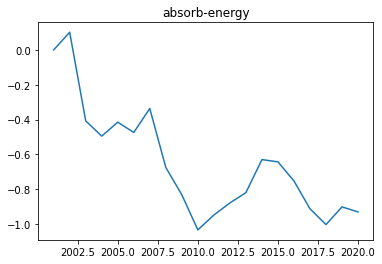

Net Radiative -0.9307645321743375
Integrated Net Radiative Energy Change -2.088969106709921e+23


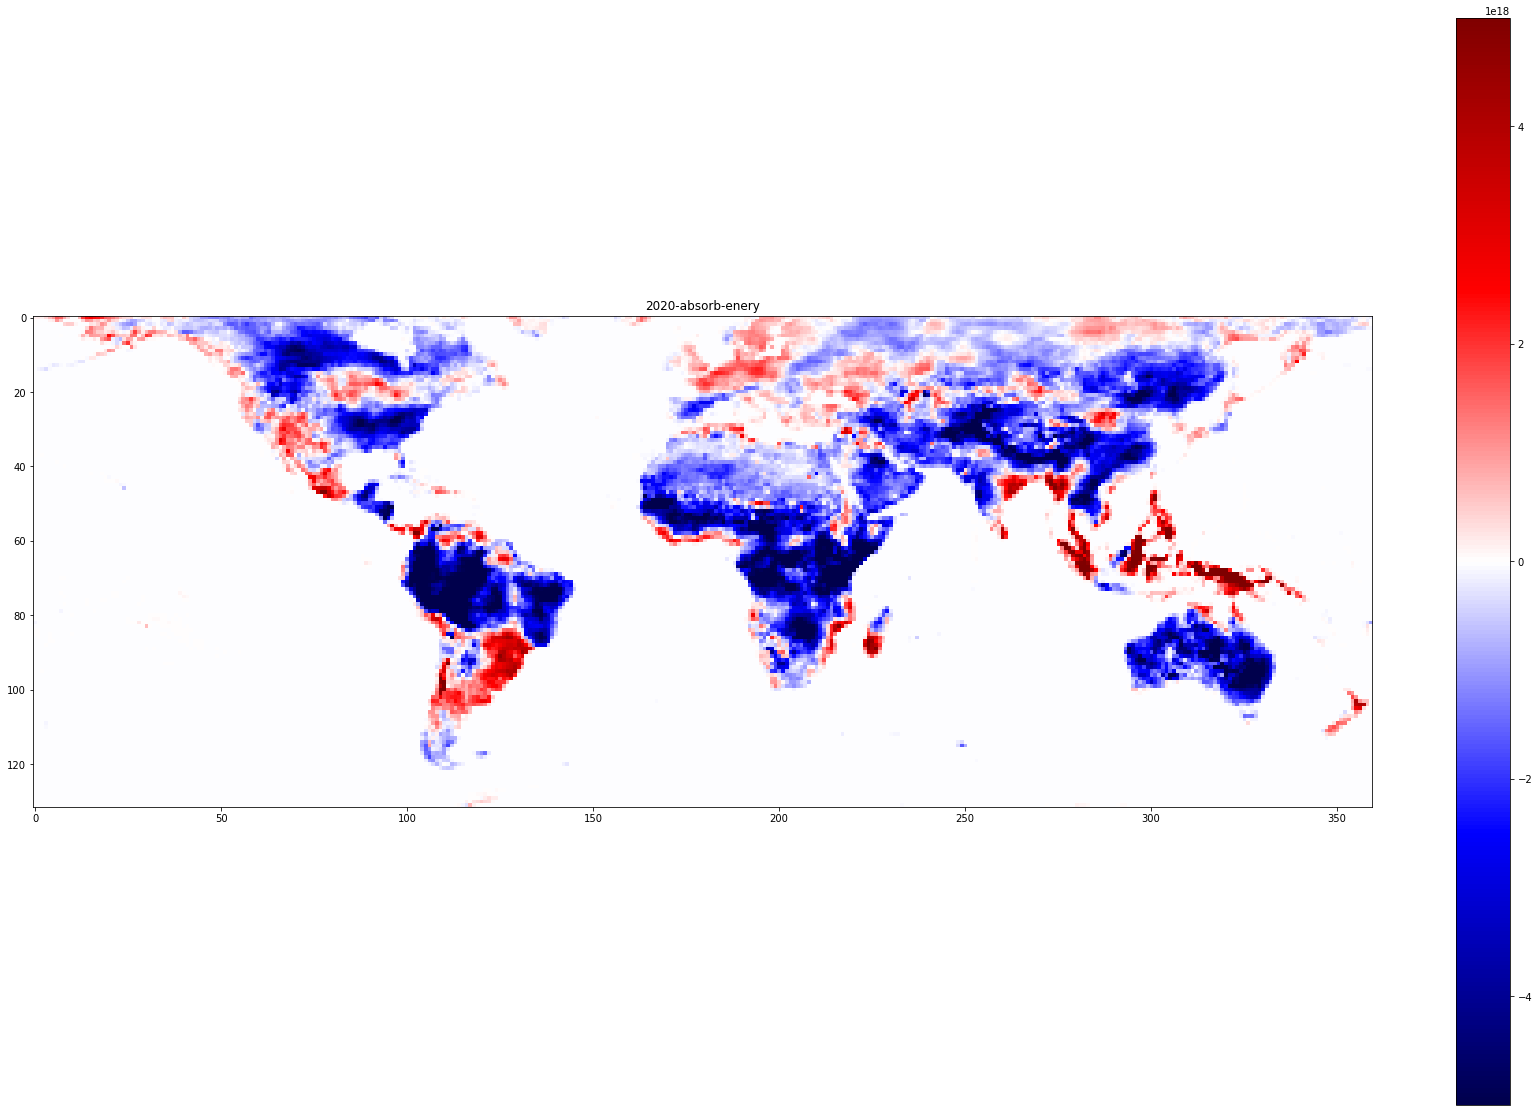

In [19]:

stat=torch.load('/data/hk/albedo/stat.pth')
kk=[]
stat_value={}
for year in range(2001,2021):

    kk.append(np.nansum(stat[year][:,24:-24]))
kk2=[0]+[kk[j]-kk[0] for j in range(1,len(kk))]
plt.plot(range(2001,2021),[i/365/24/3600/5.1e8/1e6 for i in kk2])
plt.title('absorb-energy')
plt.show()
print('Net Radiative',(kk2[-1]-kk2[0])/365/24/3600/5.1e8/1e6)
print('Integrated Net Radiative Energy Change',np.array(kk2).sum())
baseline=np.nansum(stat[2001],axis=0)[24:-24,:]
for year in range(2020,2021):
    plt.figure(figsize=(30,20))
    plt.title(f'{year}-absorb-enery')
    plt.imshow(np.nansum(stat[year],axis=0)[24:-24,:]-baseline,vmax=5e18,vmin=-5e18,cmap='seismic')
    plt.colorbar()
    plt.show()

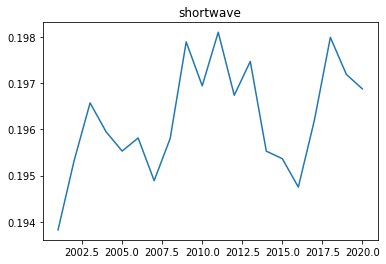

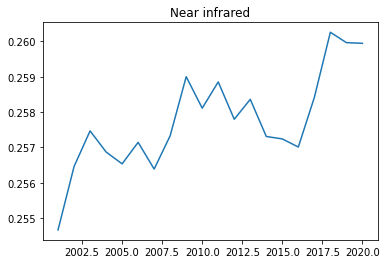

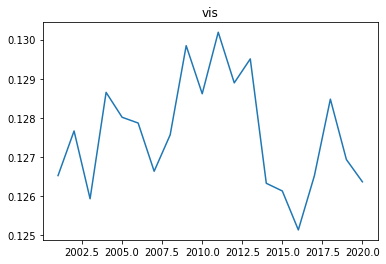

SW albedo
[0.19382409652009053, 0.19531674749989034, 0.19656846997879826, 0.19594586133711064, 0.19552866251368473, 0.19581076433448583, 0.19488863317887564, 0.19580101441672612, 0.1978879063453457, 0.19693899835582365, 0.19809634037073157, 0.19673432883826422, 0.1974662499666274, 0.19552644161157792, 0.1953640637405205, 0.19474950390008525, 0.1961905858479865, 0.19798550002941515, 0.19718452617171683, 0.19687170974731097]
Nir albedo
[0.2546670485778233, 0.25646126971178596, 0.2574696065215136, 0.25687221535693955, 0.2565369378942052, 0.2571449295347927, 0.2563891927753267, 0.25733324943258706, 0.2590031473018048, 0.2581124552994229, 0.2588552761742961, 0.2577984575441091, 0.2583624249195297, 0.2573114971928034, 0.2572420349354202, 0.2570128882414495, 0.2584173016779703, 0.2602610442035912, 0.259967081820475, 0.25994737722093164]
vis albedo
[0.12652497416232417, 0.12766559640711592, 0.1259330564976232, 0.12865190533318138, 0.12801583739468336, 0.1278685175549317, 0.12663622403168864, 0

In [14]:
stat=torch.load('/data/hk/albedo/stat_meansw.pth')
kk=[]
for y in range(2001,2021):
    mm=[]
    for m in range(1,13):
        a=np.nansum(stat[f'{y}-{m}-albedo'][:,24:-24,:],axis=0)
        a[a==0]=np.nan
        mm.append(a)
    ay=np.nanmean(np.stack(mm),axis=0)
    kk.append(np.nansum(ay)/126975430)
plt.plot(list(range(2001,2021)),kk,label='shortwave')
plt.title('shortwave')
plt.show()




stat=torch.load('/data/hk/albedo/stat_meansw_nir.pth')
kk2=[]
for y in range(2001,2021):
    mm=[]
    for m in range(1,13):
        a=np.nansum(stat[f'{y}-{m}-albedo'][:,24:-24,:],axis=0)
        a[a==0]=np.nan
        mm.append(a)
    ay=np.nanmean(np.stack(mm),axis=0)
    kk2.append(np.nansum(ay)/126975430)
plt.plot(list(range(2001,2021)),kk2,label='Near infrared')
plt.title('Near infrared')
plt.show()



stat=torch.load('/data/hk/albedo/stat_meansw_vis.pth')
kk3=[]
for y in range(2001,2021):
    mm=[]
    for m in range(1,13):
        a=np.nansum(stat[f'{y}-{m}-albedo'][:,24:-24,:],axis=0)
        a[a==0]=np.nan
        mm.append(a)
    ay=np.nanmean(np.stack(mm),axis=0)
    kk3.append(np.nansum(ay)/126975430)
plt.plot(list(range(2001,2021)),kk3,label='vis')
plt.title('vis')
plt.show()
# plt.legend()

plt.show()
print('SW albedo')
print(kk)
print('Nir albedo')
print(kk2)
print('vis albedo')
print(kk3)

In [28]:
0.19687170974731097-0.19382409652009053

0.0030476132272204415

In [16]:
0.25994737722093164/0.2546670485778233

1.0207342436824713

In [17]:
0.12636588826673004/0.12652497416232417

0.9987426522182883

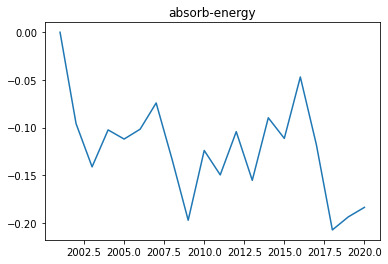

RF -0.18360991228588816
integrated RF -3.925791398058563e+22


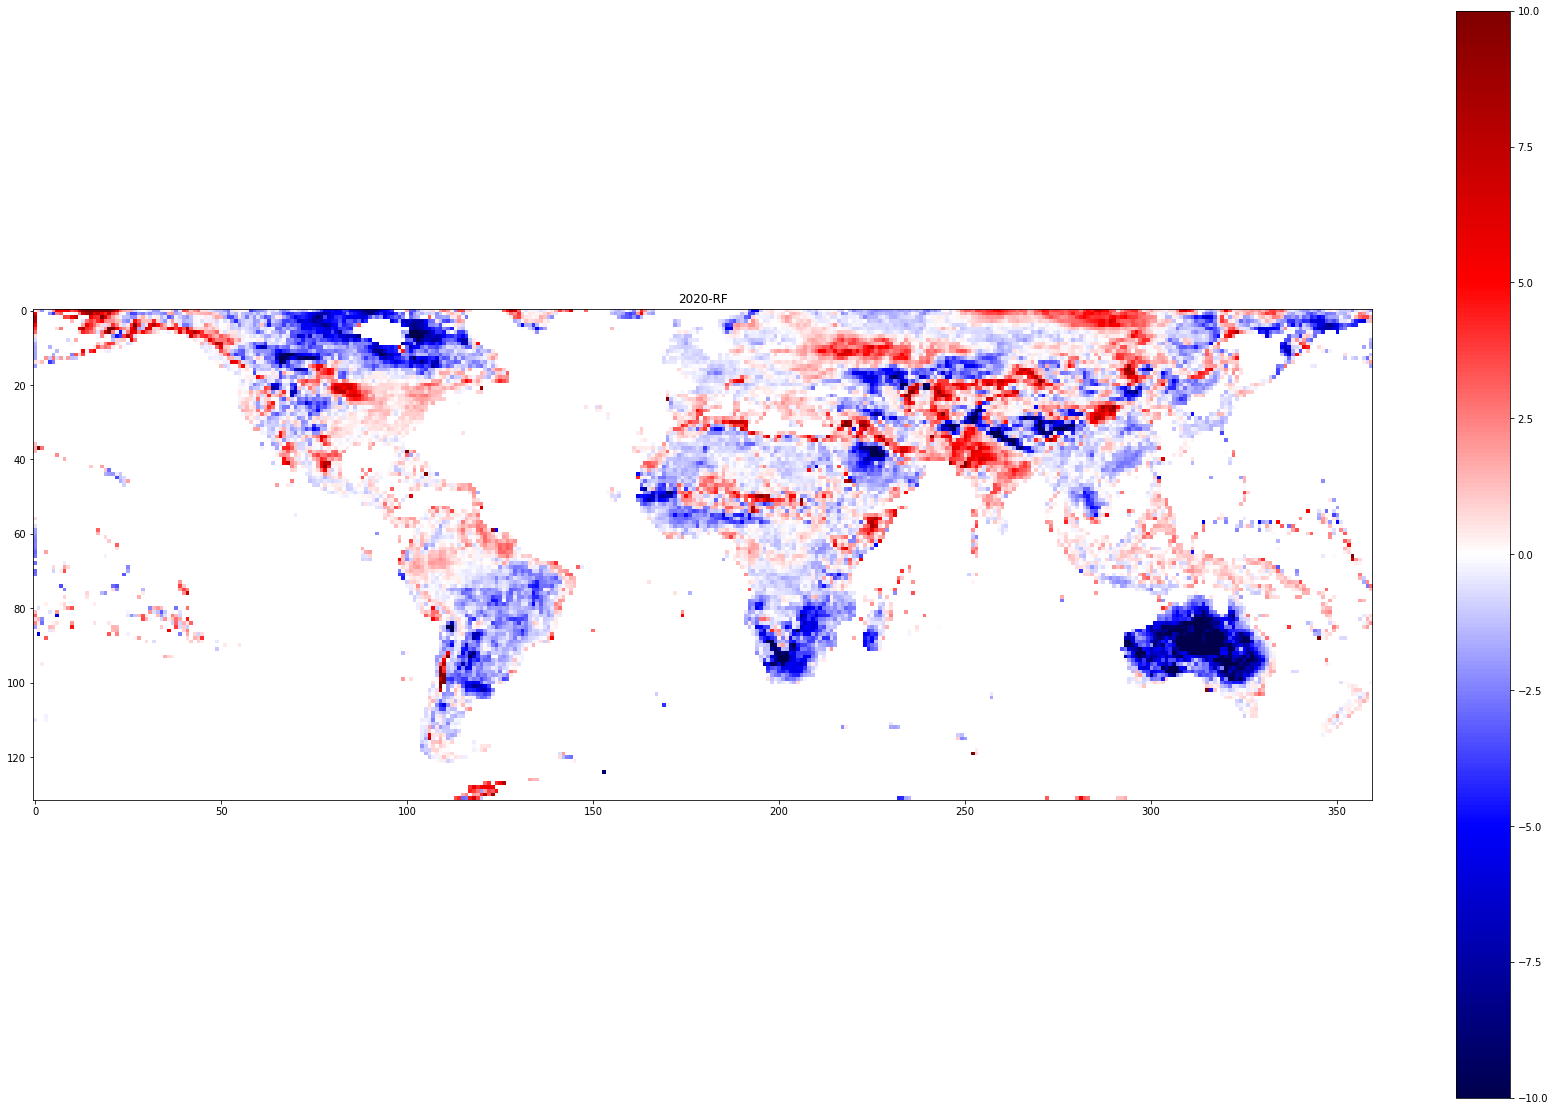

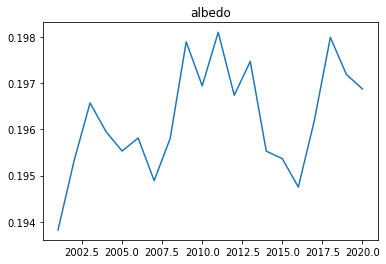

albedo
[0.19382409652009053, 0.19531674749989034, 0.19656846997879826, 0.19594586133711064, 0.19552866251368473, 0.19581076433448583, 0.19488863317887564, 0.19580101441672612, 0.1978879063453457, 0.19693899835582365, 0.19809634037073157, 0.19673432883826422, 0.1974662499666274, 0.19552644161157792, 0.1953640637405205, 0.19474950390008525, 0.1961905858479865, 0.19798550002941515, 0.19718452617171683, 0.19687170974731097]


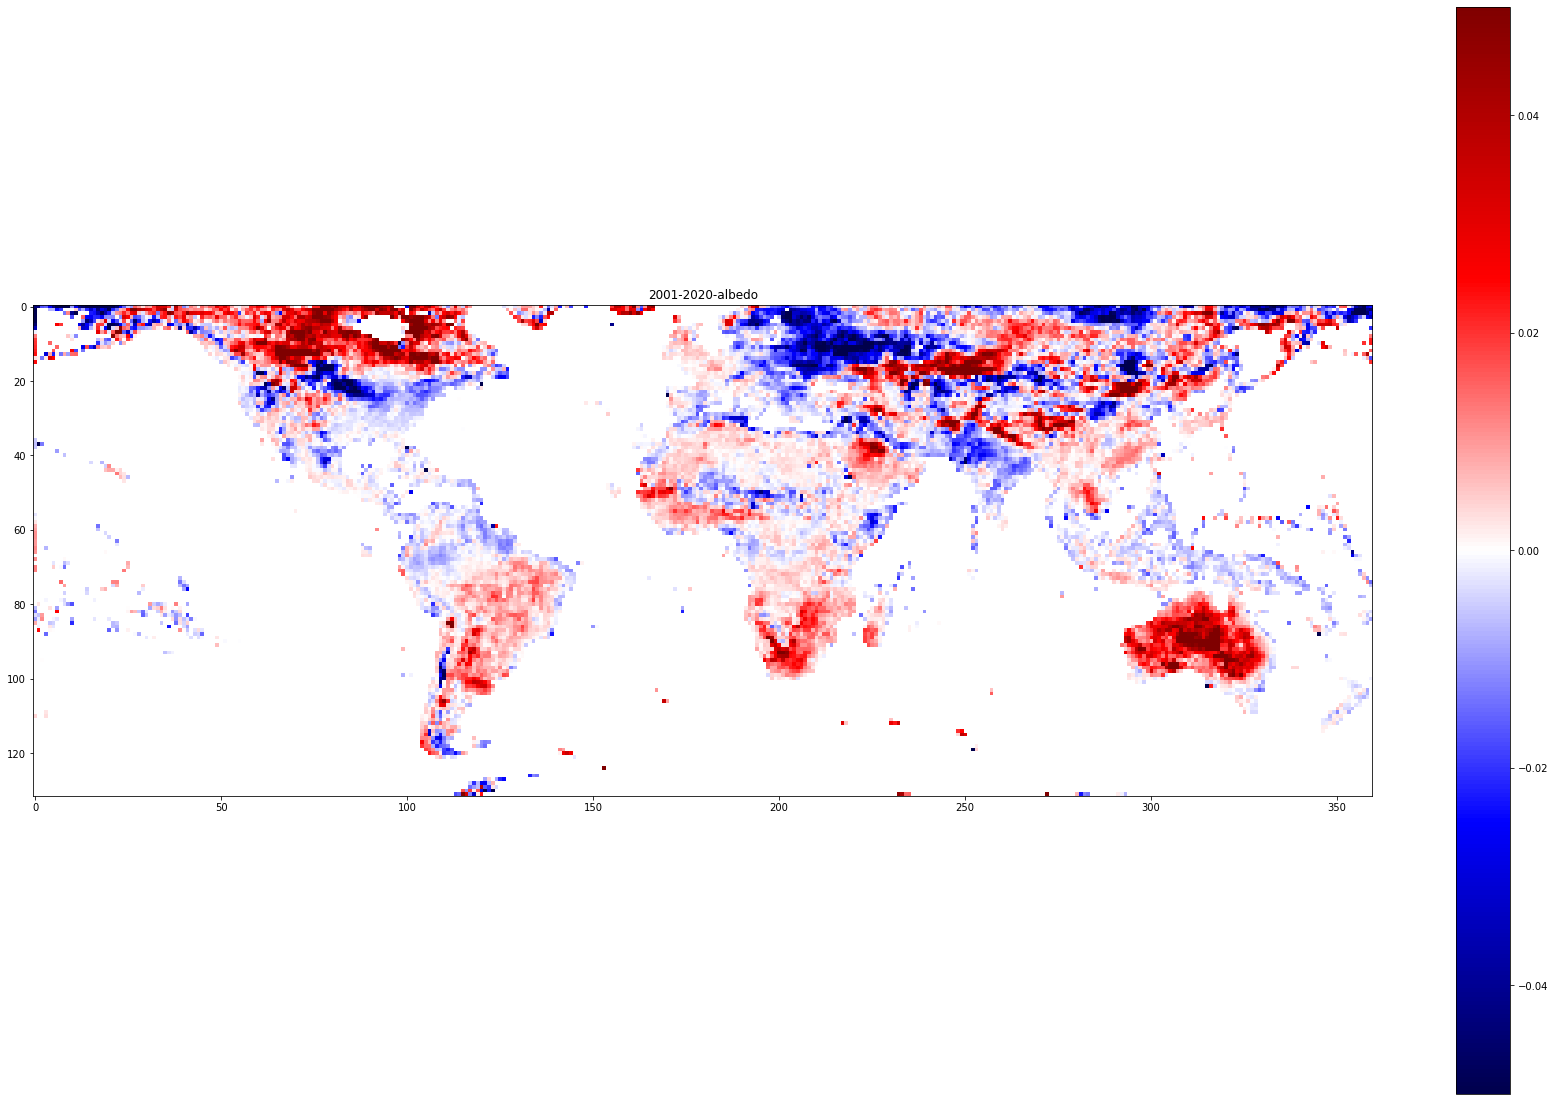

In [20]:
#辐射强迫
stat=torch.load('/data/hk/albedo/stat_meansw.pth')
kk=[]
stat_value={}
for year in range(2001,2021):

    kk.append(np.nansum(stat[year][:,24:-24]))
kk2=[0]+[kk[j]-kk[0] for j in range(1,len(kk))]
plt.plot(range(2001,2021),[i/365/24/3600/5.1e8/1e6 for i in kk2])
plt.title('absorb-energy')
plt.show()
print('RF',(kk2[-1]-kk2[0])/365/24/3600/5.1e8/1e6)
print('integrated RF',np.array(kk2).sum())

end_y=2020
baseline_y=2001
NC=nc.Dataset(root_path+f'information_fill/month_{month}.nc','r')
ll=NC.variables['area-land'][:][:,24:-24,:]
landarea_end=ll[end_y-2001]
landarea_baseline=ll[baseline_y-2001,:]
NC.close()


baseline=np.nansum(stat[baseline_y],axis=0)[24:-24,:]

plt.figure(figsize=(30,20))
plt.title(f'2020-RF')
plt.imshow((np.nansum(stat[end_y],axis=0)[24:-24,:]/landarea_end-baseline/landarea_baseline)/365/24/3600/1e6,vmax=10,vmin=-10,cmap='seismic')
plt.colorbar()
plt.show()



kk=[]
for y in range(2001,2021):
    mm=[]
    for m in range(1,13):
        a=np.nansum(stat[f'{y}-{m}-albedo'][:,24:-24,:],axis=0)
        a[a==0]=np.nan
        mm.append(a)
    ay=np.nanmean(np.stack(mm),axis=0)
    kk.append(np.nansum(ay)/126975430)
plt.plot(list(range(2001,2021)),kk)
plt.title('albedo')
plt.show()
print('albedo')
print(kk)


baseline_y=2001
mm=[]
for m in range(1,13):
    a=np.nansum(stat[f'{baseline_y}-{m}-albedo'][:,24:-24,:],axis=0)
    a[a==0]=np.nan
    mm.append(a)
baseline=np.nanmean(np.stack(mm),axis=0)
baseline[np.isnan(baseline)]=0

end_y=2020
mm=[]
for m in range(1,13):
    a=np.nansum(stat[f'{end_y}-{m}-albedo'][:,24:-24,:],axis=0)
    a[a==0]=np.nan
    mm.append(a)
end=np.nanmean(np.stack(mm),axis=0)
end[np.isnan(end)]=0
plt.figure(figsize=(30,20))
plt.title(f'{baseline_y}-{end_y}-albedo')
plt.imshow(end/landarea_end-baseline/landarea_baseline,vmax=0.05,vmin=-0.05,cmap='seismic')
plt.colorbar()
plt.show()

In [22]:
type_code={0:'EN_Forests',#Evergreen_Needleleaf_Forests
           1:'EB_Forests',#Evergreen_Broadleaf_Forests
           2:'DN_Forests',#Deciduous_Needleleaf_Forests
           3:'DB_Forests',#Deciduous_Broadleaf_Forests
           4:'M_Forests',#Mixed_Forests
           5:'C_Shrublands',#CLosed_Shrublands
           6:'O_Shrublands',#Open_Shrublands
           7:'W_Savannas',#Woody_Savannas
           8:'Savannas',
           9:'Grasslands',
           10:'Permanent_Wetlands',
           11:'Croplands',
           12:'Urban',
           13:'Cropland Natural_Mosaics',#Cropland/Natural_Vegetation_Mosaics
           14:'Permanent_Snow',
           15:'Barren',
           16:'Water_Bodies',
           17:'Snow'
           }

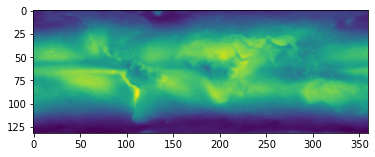

In [23]:
#SW分布
sw=[]
for month in range(1,13):
    sw.append(torch.load(f"/data/hk/albedo/SW_MERRA2/2016_{month}_SW_1degree.tif"))
sw=np.sum(np.stack(sw),axis=0)
plt.imshow(sw[24:-24,:])
plt.show()

In [24]:
landtypes=['landtype'+str(i) for i in range(1,18)]+['snow']

area=np.zeros((20,12,18))
for month in range(1,13):
    NC=nc.Dataset(root_path+f'information_fill/month_{month}.nc','r')
    for year in range(2001,2021):
        tt=0
        for type in landtypes:
            area_type=NC.variables[f'area-{type}'][year-2001]  
            area[year-2001,month-1,tt]=np.nansum(area_type[24:-24])
            tt+=1
    NC.close()  
# 面积变化
area_y=np.mean(area,axis=1)
p=0
print('面积占比        面积变化比例        面积变化值')
for t in range(18):
    print(type_code[t])
    print(area_y[0,t]/126975430*100,(area_y[-1,t]/area_y[0,t]-1)*100,(area_y[-1,t]-area_y[0,t])/10000)
    p+=area_y[0,t]/126975430*100

面积占比        面积变化比例        面积变化值
EN_Forests
1.7822570821378594 -4.125038558555927 -9.335080208333348
EB_Forests
10.024182959385659 -4.9520570035445965 -63.0310166666666
DN_Forests
0.28123758495049 -3.750931314527628 -1.3394674479166686
DB_Forests
2.1820409304120227 1.0958837280712785 3.0363166666666976
M_Forests
3.252989738513454 6.424029610233117 26.53443958333335
C_Shrublands
0.46006773055753114 -9.409312552720973 -5.496666145833325
O_Shrublands
7.340745896010485 2.3089427175667643 21.521525
W_Savannas
7.592255873176934 4.806727802704991 46.3382958333334
Savannas
11.36525848609714 -1.1383579764123852 -16.42774166666679
Grasslands
20.25924648046739 1.2016034769557926 30.91036666666679
Permanent_Wetlands
0.8671660106473615 3.7366169511199088 4.114343229166675
Croplands
8.391328083446274 3.781528289981151 40.2919
Urban
0.5765154107964037 9.519673028708354 6.9687140625
Cropland Natural_Mosaics
0.9579872722882949 13.428408076878506 16.334429166666673
Permanent_Snow
0.0 nan 0.0
Barren
15.49

In [25]:
#雪面积与反照率相关系数（去趋势）
kk=[0.19371519356146302, 0.1952117035555619, 0.1964632685236821, 0.19583706863603453, 0.19541815294502252, 0.19570038077445376, 0.1947786748979704, 0.19568870922508394, 0.19777723926589577, 0.19682875655550053, 0.19798266483523624, 0.19662255918330027, 0.19735147185561805, 0.19541889324572478, 0.19525881503216805, 0.19464557828234957, 0.1960842975684351, 0.19787721136285974, 0.1970765997799732, 0.19676813065330828]
np.corrcoef([area_y[i+1,17]-area_y[i,17] for i in range(17)],[kk[i+1]-kk[i] for i in range(17)])

array([[1.        , 0.83512074],
       [0.83512074, 1.        ]])

In [27]:
#反照率变化
print('增减比例    2001年反照率     2020年   类别')
aaaa=[]
for t in range(18):
    kk=[]
    for y in range(2001,2021):
        mm=[]
        for m in range(1,13):
            a=np.nansum(stat[f'{y}-{m}-albedo'][t,24:-24,:],axis=0)/area[y-2001,m-1,t]
            a[a==0]=np.nan
            mm.append(a)
        ay=np.nanmean(np.stack(mm),axis=0)
        kk.append(np.nansum(ay))
    kk=[kk[i]for i in range(20)]
    aaaa.append((kk[-1]/kk[0]-1)*100)
    print(aaaa[t],kk[0],kk[-1],type_code[t])

增减比例    2001年反照率     2020年   类别
2.804720401763916 0.11212668 0.11527152 EN_Forests
-1.6329944133758545 0.12109782 0.1191203 EB_Forests
-2.0867526531219482 0.15794727 0.1546513 DN_Forests
1.4312744140625 0.12736805 0.12919104 DB_Forests
1.9017934799194336 0.12660612 0.12901391 M_Forests
10.291051864624023 0.124072105 0.13684043 C_Shrublands
9.113538265228271 0.1759245 0.19195744 O_Shrublands
3.350710868835449 0.13351288 0.13798651 W_Savannas
2.187824249267578 0.13809527 0.14111656 Savannas
3.0242204666137695 0.16517746 0.1701728 Grasslands
0.4494309425354004 0.12991434 0.13049822 Permanent_Wetlands
2.993619441986084 0.15702534 0.16172607 Croplands
0.44378042221069336 0.14395493 0.14459378 Urban
1.726090908050537 0.14768183 0.15023096 Cropland Natural_Mosaics
nan 0.0 0.0 Permanent_Snow
1.0352492332458496 0.30155239 0.3046742 Barren
8.379018306732178 0.05725352 0.062050804 Water_Bodies
0.5169034004211426 0.4951128 0.49767205 Snow


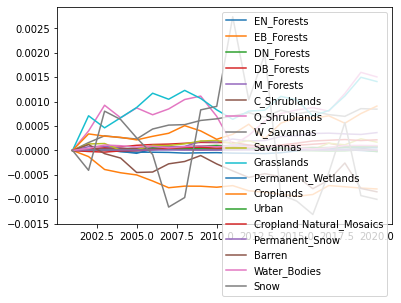

导致总反照率的变化    贡献百分比
-2.212854289999227e-05       -0.7260942006139829 EN_Forests
-0.0007895533411463942       -25.907268484541323 EB_Forests
-2.1925686233155483e-05       -0.7194379535211783 DN_Forests
7.355261565170513e-05       2.4134498103221707 DB_Forests
0.0003651582436066565       11.981777751361745 M_Forests
-4.5628906316763206e-07       -0.014972013479013148 C_Shrublands
0.0015064075782220236       49.429093060996266 O_Shrublands
0.0008455297217737322       27.743996981693535 W_Savannas
0.00016937036558962656       5.557475734678441 Savannas
0.0014112533424773602       46.30683873768607 Grasslands
5.3633284604746e-05       1.7598455120783791 Permanent_Wetlands
0.0009090459469205982       29.828127099634898 Croplands
8.30132303942582e-05       2.7238768244213833 Urban
0.00021725462949800608       7.1286811448889775 Cropland Natural_Mosaics
0.0       0.0 Permanent_Snow
-0.0008483373515647818       -27.83612251015537 Barren
9.804345120154349e-05       3.217056886544736 Water_Bodies


In [29]:
zzzz=[]
w=[]
for t in range(18):
    kk=[]
    for y in range(2001,2021):
        mm=[]
        for m in range(1,13):
            a=np.nansum(stat[f'{y}-{m}-albedo'][t,24:-24,:],axis=0)
            a[a==0]=np.nan
            mm.append(a)
        ay=np.nanmean(np.stack(mm),axis=0)
        kk.append(np.nansum(ay)/126975430)
    w.append(np.array(kk).sum())
    kk=[kk[i]-kk[0] for i in range(20)]
    
    zzzz.append(kk[-1])
    plt.plot(list(range(2001,2021)),kk,label=type_code[t])
plt.legend()
plt.show()
#反照率变化的绝对贡献
print('导致总反照率的变化    贡献百分比')
for t in range(18):
    print(zzzz[t],'     ',zzzz[t]/0.0030476132272204415*100,type_code[t])
    

In [30]:
#20年平均反照率权重
ww=w/np.array(w).sum()*100
for t in range(18):
    print(ww[t],type_code[t])

1.0125502075376764 EN_Forests
5.8481846368344375 EB_Forests
0.23086677604969721 DN_Forests
1.4663234641932554 DB_Forests
2.161771645139284 M_Forests
0.3059369348626161 C_Shrublands
6.967665619089329 O_Shrublands
5.384705035668571 W_Savannas
8.010291740767016 Savannas
17.47414552760024 Grasslands
0.54313899790206 Permanent_Wetlands
6.940595865983831 Croplands
0.442522232417455 Urban
0.7636334807147985 Cropland Natural_Mosaics
0.0 Permanent_Snow
23.605001194625032 Barren
0.6055113178901562 Water_Bodies
18.23715532272454 Snow


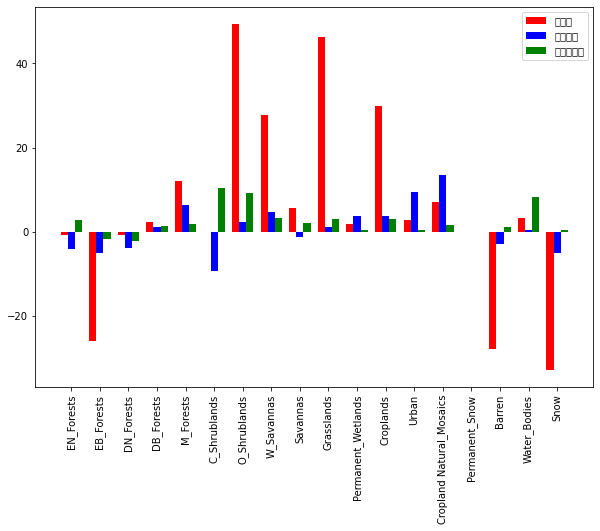

In [31]:
shops = [type_code[i] for i in range(18)]
sales_product_1 = [zzzz[t]/0.003052937091845259*100 for t in range(18)]
sales_product_2 = [(area_y[-1,t]/area_y[0,t]-1)*100 for t in range(18)]
sales_product_3 = [aaaa[t] for t in range(18)]

# 创建分组柱状图，需要自己控制x轴坐标
xticks = np.arange(len(shops))


fig, ax = plt.subplots(figsize=(10, 7))
# 所有门店第一种产品的销量，注意控制柱子的宽度，这里选择0.25
ax.bar(xticks, sales_product_1, width=0.25, label="贡献比", color="red")
# 所有门店第二种产品的销量，通过微调x轴坐标来调整新增柱子的位置
ax.bar(xticks + 0.25, sales_product_2, width=0.25, label="面积变化", color="blue")
# 所有门店第三种产品的销量，继续微调x轴坐标调整新增柱子的位置
ax.bar(xticks + 0.5, sales_product_3, width=0.25, label="反照率变化", color="green")
ax.legend()
ax.set_xticks(xticks + 0.25)
ax.set_xticklabels(shops)
plt.xticks(rotation=90)
plt.show()

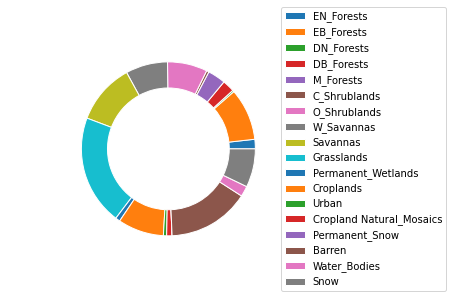

In [32]:
#面积占比
aa=np.mean(area_y,axis=0)
aa=aa/aa.sum()
l=[type_code[i] for i in range(18)]
plt.pie(aa,labels=l,
         textprops=dict(color='w'),wedgeprops=dict(width=0.3,edgecolor='w'))
# plt.pie(ww,labels=l,
#          radius=0.7,wedgeprops=dict(width=0.3,edgecolor='w'),textprops={'size':"smaller"})


 
plt.legend(labels=l,loc="right",bbox_to_anchor=(1.5,0,0.3,1))
plt.show()

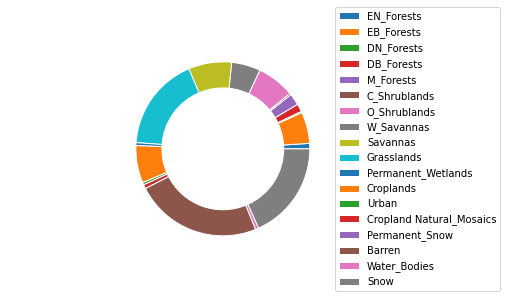

In [33]:
#反照率权重占比
l=[type_code[i] for i in range(18)]
plt.pie(ww,labels=l,
         textprops=dict(color='w'),wedgeprops=dict(width=0.3,edgecolor='w'))
# plt.pie(ww,labels=l,
#          radius=0.7,wedgeprops=dict(width=0.3,edgecolor='w'),textprops={'size':"smaller"})


 
plt.legend(labels=l,loc="right",bbox_to_anchor=(1.5,0,0.3,1))
plt.show()

In [ ]:
#O_Shrublands
NC=nc.Dataset(root_path+f'information_fill/month_1.nc','r')
land=NC.variables['area-landtype7'][:]
NC.close()
plt.imshow(land[0])

In [ ]:
#Barren
NC=nc.Dataset(root_path+f'information_fill/month_1.nc','r')
land=NC.variables['area-landtype16'][:]
NC.close()
plt.imshow(land[0])

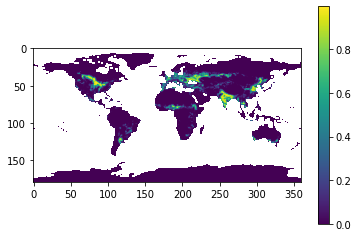

In [35]:
#Croplands
NC=nc.Dataset(root_path+f'information_fill/month_6.nc','r')
land=NC.variables['area-landtype12'][:]
land_all=NC.variables['area-land'][:]
NC.close()
land_all[land_all==0]=np.nan
plt.imshow(land[0]/land_all[0])
plt.colorbar()
plt.show()

# confuse matrix

In [ ]:
#合并
for y in range(2002,2021):
    for m in range(1,13):
        all={}
        for p in glob(f'/data/hk/albedo/confuse_matrix/result2_{y}_{m}_*.pth'):
            all.update(torch.load(p))
        print(y,m,len(all.keys()))
        torch.save(all,f'/data/hk/albedo/confuse_matrix/result2_{y}_{m}_all.pth')

In [290]:
#转换成矩阵
for year in range(2002,2021):
    print(year)
    data_m=[]
    for month in range(1,13):
        # print(month)
        data_m.append(convert_to_matrix(year,month))
    data_m=np.stack(data_m)
    torch.save(data_m,f'/data/hk/albedo/confuse_matrix/confuse_matrix_{year}.pth')

2002


100%|██████████| 180/180 [00:00<00:00, 420.02it/s]


2003


100%|██████████| 180/180 [00:00<00:00, 417.81it/s]


2004


100%|██████████| 180/180 [00:00<00:00, 419.54it/s]


2005


100%|██████████| 180/180 [00:00<00:00, 404.15it/s]


2006


100%|██████████| 180/180 [00:00<00:00, 419.61it/s]


2007


100%|██████████| 180/180 [00:00<00:00, 420.62it/s]


2008


100%|██████████| 180/180 [00:00<00:00, 414.69it/s]


2009


100%|██████████| 180/180 [00:00<00:00, 419.81it/s]


2010


100%|██████████| 180/180 [00:00<00:00, 422.31it/s]


2011


100%|██████████| 180/180 [00:00<00:00, 423.38it/s]


2012


100%|██████████| 180/180 [00:00<00:00, 433.30it/s]


2013


100%|██████████| 180/180 [00:00<00:00, 424.24it/s]


2014


100%|██████████| 180/180 [00:00<00:00, 414.90it/s]


2015


100%|██████████| 180/180 [00:00<00:00, 428.29it/s]


2016


100%|██████████| 180/180 [00:00<00:00, 416.21it/s]


2017


100%|██████████| 180/180 [00:00<00:00, 424.67it/s]


2018


100%|██████████| 180/180 [00:00<00:00, 423.78it/s]


2019


100%|██████████| 180/180 [00:00<00:00, 429.58it/s]


2020


100%|██████████| 180/180 [00:00<00:00, 426.84it/s]


# 分析

In [36]:
#桑基图
data_m=torch.load('/data/hk/albedo/confuse_matrix/confuse_matrix_2020.pth')
data_y=np.nanmean(data_m,axis=0)
transf=np.nansum(data_y[24:-24],axis=0)
transf=np.nansum(transf,axis=0)


land_p=[' ('+str(np.round(i*1000)/10)+'%)' for i in list(np.sum(transf,axis=1)/np.sum(transf))]
n=0
source=[]
target=[]
value=[]
for f in range(18):
    for t in range(18):
        source.append(type_code[f]+land_p[f])
        target.append(type_code[t]+'-2020')
        value.append(transf[f,t])
pp={'source':source,'target':target,'value':value}
pp=pd.DataFrame.from_dict(pp)

pp=pp[(pp['source']!='Permanent_Snow (0.0%)') & (pp['target']!='Permanent_Snow-2020')]

ROOT_PATH = "https://cdn.jsdelivr.net/gh/apache/echarts-website@asf-site/examples"
energy = ROOT_PATH + "/data/asset/data/energy.json"

data1 = requests.get(url=energy).json()['links']
pddata = pp

sankey_plot = SanKey(pandasdf=pddata, title="landcover transform")
sankey_plot()
sankey_plot.save_html(filename="test_sankey_0731003.html")


类别        减少的     未变化的     增加的
Grasslands 407.7298 2164.6958 438.6392
Barren 98.9006 1867.974 43.5036
Savannas 357.0395 1086.0692 340.6119
EB_Forests 134.0512 1138.774 71.0202
Croplands 135.1538 930.3387 175.4457
W_Savannas 301.9899 662.0401 348.3281
O_Shrublands 134.7605 797.3341 156.282
Snow 193.31705 724.00625 147.35895
M_Forests 82.8999 330.149675 109.434525
DB_Forests 72.4113875 204.6541375 75.4476125
Water_Bodies 4.113 243.724825 5.058225
EN_Forests 61.347675 164.954225 52.013375
Cropland Natural_Mosaics 43.0096 78.6312625 59.3440375
Permanent_Wetlands 22.9695375 87.119575 27.0731125
Urban 0.23605625 72.9672875 7.2047625
C_Shrublands 23.94003125 34.4772625 18.44338125
DN_Forests 18.7956921875 16.9145703125 17.4562328125


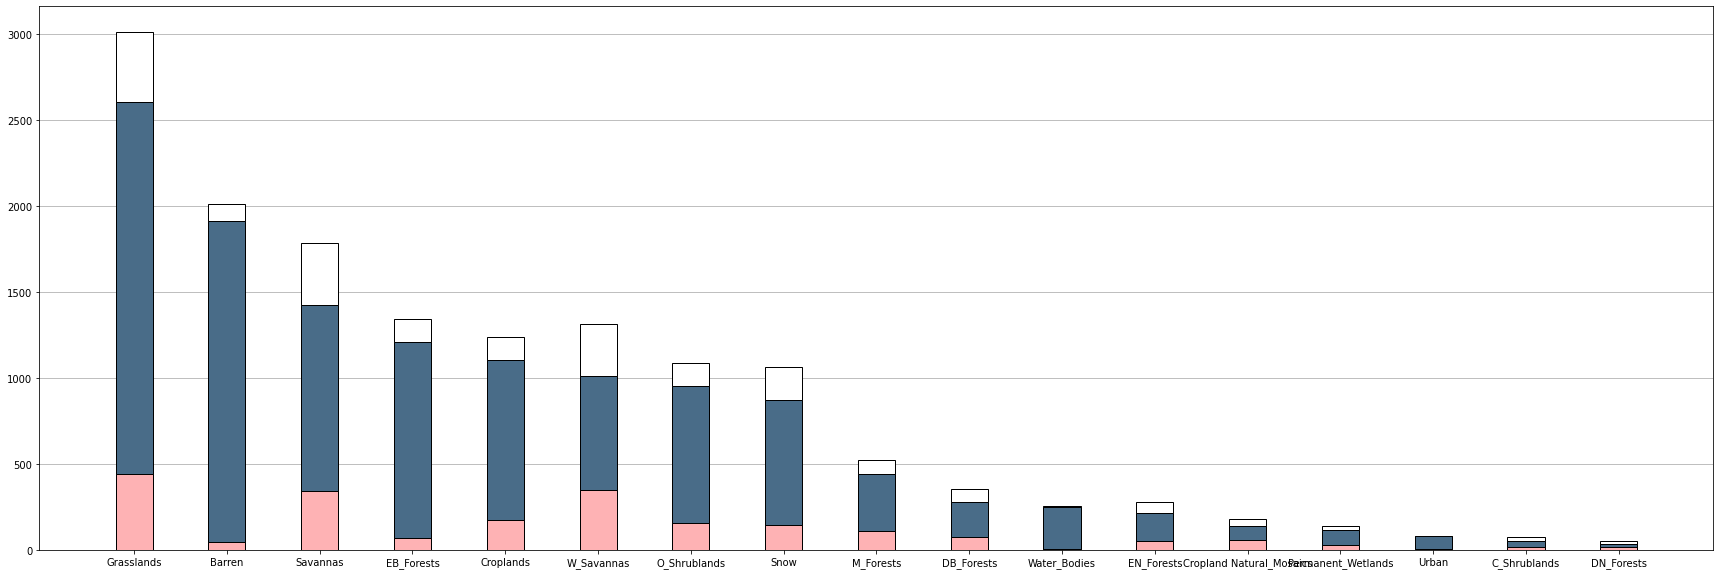

In [37]:
#landcover面积转换
nochange=[transf[i,i]/10000 for i in range(18)]
change_sub=[(np.sum(transf,axis=1)[i]-transf[i,i])/10000 for i in range(18)]
change_add=[(np.sum(transf,axis=0)[i]-transf[i,i])/10000 for i in range(18)]
    # for i in range(18):
        
    #     print(i,type_code[i],change_sub[i],nochange[i],change_add[i])
    
ii=[9,15,8,1,11,7,6,17,4,3,16,0,13,10,12,5,2] 
    
change_add2=[]
change_sub2=[]
nochange2=[]
label=[]
print('类别        减少的     未变化的     增加的')
for i in ii:
    change_add2.append(change_add[i])
    change_sub2.append(change_sub[i])
    nochange2.append(nochange[i])
    label.append(type_code[i])
    print(type_code[i],change_sub[i],nochange[i],change_add[i])
    
kk=[nochange2[i]+change_add2[i] for i in range(17)]
plt.figure(figsize=(30,10))
plt.bar(label,change_add2,width=0.4,label='NO',color='#FEB2B4',edgecolor='black',zorder=5)
plt.bar(label,nochange2,width=0.4,bottom=change_add2,label='NO2',color='#496C88',edgecolor='black',zorder=5)
plt.bar(label,change_sub2,width=0.4,bottom=kk,label='NO2',color='white',edgecolor='black',zorder=5)
plt.grid(b=None, which='major', axis='y', )
plt.savefig('bar1.png', dpi=600)
plt.show()

In [38]:
print('单位:e4 km2')
print('总面积：',(np.array(nochange2).sum()+np.array(change_add2).sum()))
print('土地类型改变的区域的面积:',np.array(change_add2).sum())
print('土地类型未改变的区域的面积:',np.array(nochange2).sum())
print('土地类型改变的区域的面积比例：',np.array(change_add2).sum()/(np.array(nochange2).sum()+np.array(change_add2).sum()))

单位:e4 km2
总面积： 12697.489884375
土地类型改变的区域的面积: 2092.6649140624995
土地类型未改变的区域的面积: 10604.8249703125
土地类型改变的区域的面积比例： 0.16480933894167898


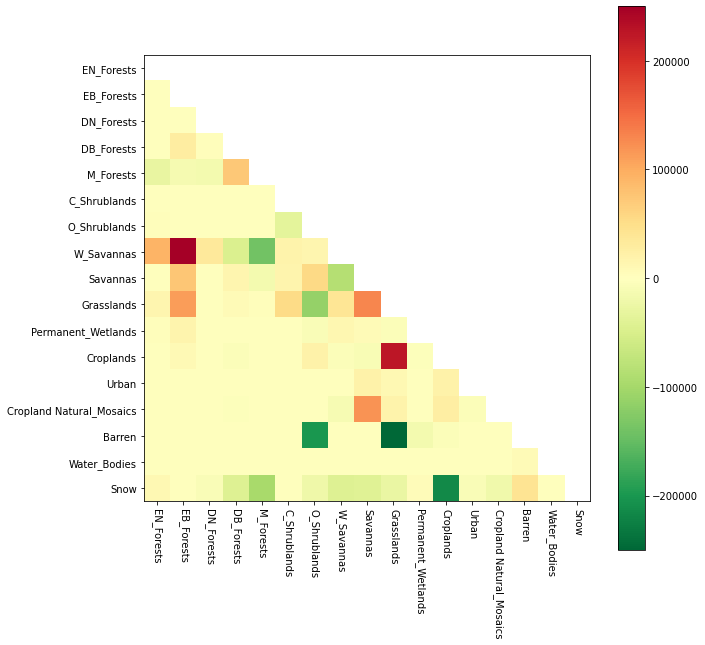

In [39]:
transf2=transf.copy()
transf22=np.zeros((18,18))
for i in range(18):
    transf22[i,i]=0
for x in range(18):
    for y in range(18):
        transf22[x,y]=(transf2[y,x]-transf2[x,y])
        transf22[y,x]=0
transf22[transf22==0]=np.nan
transf3=np.zeros((17,17))
transf3[:14,:14]=transf22[:14,:14]
transf3[14:,:14]=transf22[15:,:14]

transf3[:14,14:]=transf22[:14,15:]
transf3[14:,14:]=transf22[15:,15:]


ll=[type_code[i] for i in range(18) if i!=14]


initial_cmap = cm.get_cmap('RdYlGn')
reversed_cmap = initial_cmap.reversed()
#x to y 减去y to x
plt.figure(figsize=(10,10))
plt.imshow(transf3,vmax=250000,vmin=-250000,cmap=reversed_cmap)
plt.yticks([i for i in range(17)],ll)
plt.xticks([i for i in range(17)],ll)
plt.xticks(rotation=-90)
plt.colorbar()
plt.show()

In [40]:
from tool import *
WB_sky_fraction=torch.load("/data/hk/albedo/white_sky_fraction/white_sky_fraction.pth")
landtypes=['landtype'+str(i) for i in range(1,18)]+['snow']
stat={}
for month in range(1,13):
    NC=nc.Dataset(root_path+f'information_fill/month_{month}.nc','r')
    for year in [2001,2020]:
        types_stat=[]
        types_stat_albedo=[]
        sw=torch.load(f"/data/hk/albedo/SW_MERRA2/{month}_SW_1degree.tif")
        for type in landtypes:
            now=datetime.datetime.strptime(f'2001-{month}-1', '%Y-%m-%d')
            month_time=(now+relativedelta(months=1)-now).total_seconds()
            bs=NC.variables[f'albedo_BSA_shortwave-{type}'][year-2001]
            ws=NC.variables[f'albedo_WSA_shortwave-{type}'][year-2001]
            area_type=NC.variables[f'area-{type}'][year-2001] 
            area_land=NC.variables[f'area-land'][year-2001] 
            wf=WB_sky_fraction[(year-2001)*12+month-1]
            # area=NC.variables['area-grid'][year-2001]
            types_stat.append(((ws*wf+bs*(1-wf))/1000)*1e6*sw*month_time)
            types_stat_albedo.append(((ws*wf+bs*(1-wf))/1000))
                            #   (1-(ws*wf+bs*(1-wf))/1000)*area_type*1e6*month_time
            # types_stat.append((ws*wf+bs*(1-wf))*area_type)
        types_stat=np.stack(types_stat)
        types_stat_albedo=np.stack(types_stat_albedo)
        stat[f'{year}-{month}']=types_stat  
        stat[f'{year}-{month}-albedo']=types_stat_albedo
    NC.close()  
    
    
a=[]
for m in range(1,13):
    exp1_2020=np.expand_dims(stat[f'2020-{m}'],0).repeat(18,axis=0)
    exp0_2001=np.expand_dims(stat[f'2001-{m}'],1).repeat(18,axis=1)
    dif_rf=(exp0_2001-exp1_2020).transpose((2,3,0,1))*data_m[m-1]
    a.append(dif_rf[24:-24])
# a+=[np.nansum(dif_rf[24:-24])]    
print('RF all:',np.nansum(np.array(a))/365/24/3600/5.1e8/1e6)

RF all: -0.18361318497397358


In [41]:
a_y=np.stack(a,axis=0)
a_y=np.nansum(a_y,axis=0)
a_transf=np.sum(np.sum(a_y,axis=0),axis=0)
#nochange区域辐射强迫
nc=0
for i in range(18):
    nc+=a_transf[i,i]
print('nochange area RF:',nc/365/24/3600/5.1e8/1e6)
print('change area RF:',a_transf.sum()/365/24/3600/5.1e8/1e6-nc/365/24/3600/5.1e8/1e6)

nochange area RF: -0.17411635929332933
change area RF: -0.009497245704783525


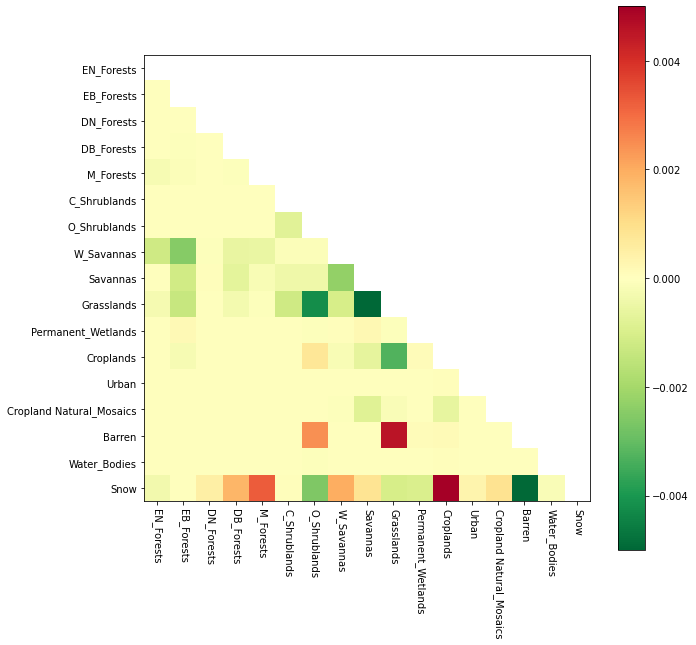

In [42]:
transf2=a_transf.copy()
transf2=transf2/365/24/3600/5.1e8/1e6
transf22=np.zeros((18,18))
for i in range(18):
    transf22[i,i]=0
for x in range(18):
    for y in range(18):
        transf22[x,y]=(transf2[x,y]+transf2[y,x])
        transf22[y,x]=0
transf22[transf22==0]=np.nan
transf3=np.zeros((17,17))
transf3[:14,:14]=transf22[:14,:14]
transf3[14:,:14]=transf22[15:,:14]

transf3[:14,14:]=transf22[:14,15:]
transf3[14:,14:]=transf22[15:,15:]

#A/B转换造成的辐射强迫
from matplotlib import cm
ll=[type_code[i] for i in range(18) if i!=14]
initial_cmap = cm.get_cmap('RdYlGn')
reversed_cmap = initial_cmap.reversed()
plt.figure(figsize=(10,10))
plt.imshow(transf3,vmax=0.005,vmin=-0.005,cmap=reversed_cmap)
plt.yticks([i for i in range(17)],ll)
plt.xticks([i for i in range(17)],ll)
plt.xticks(rotation=-90)
plt.colorbar()
plt.show()

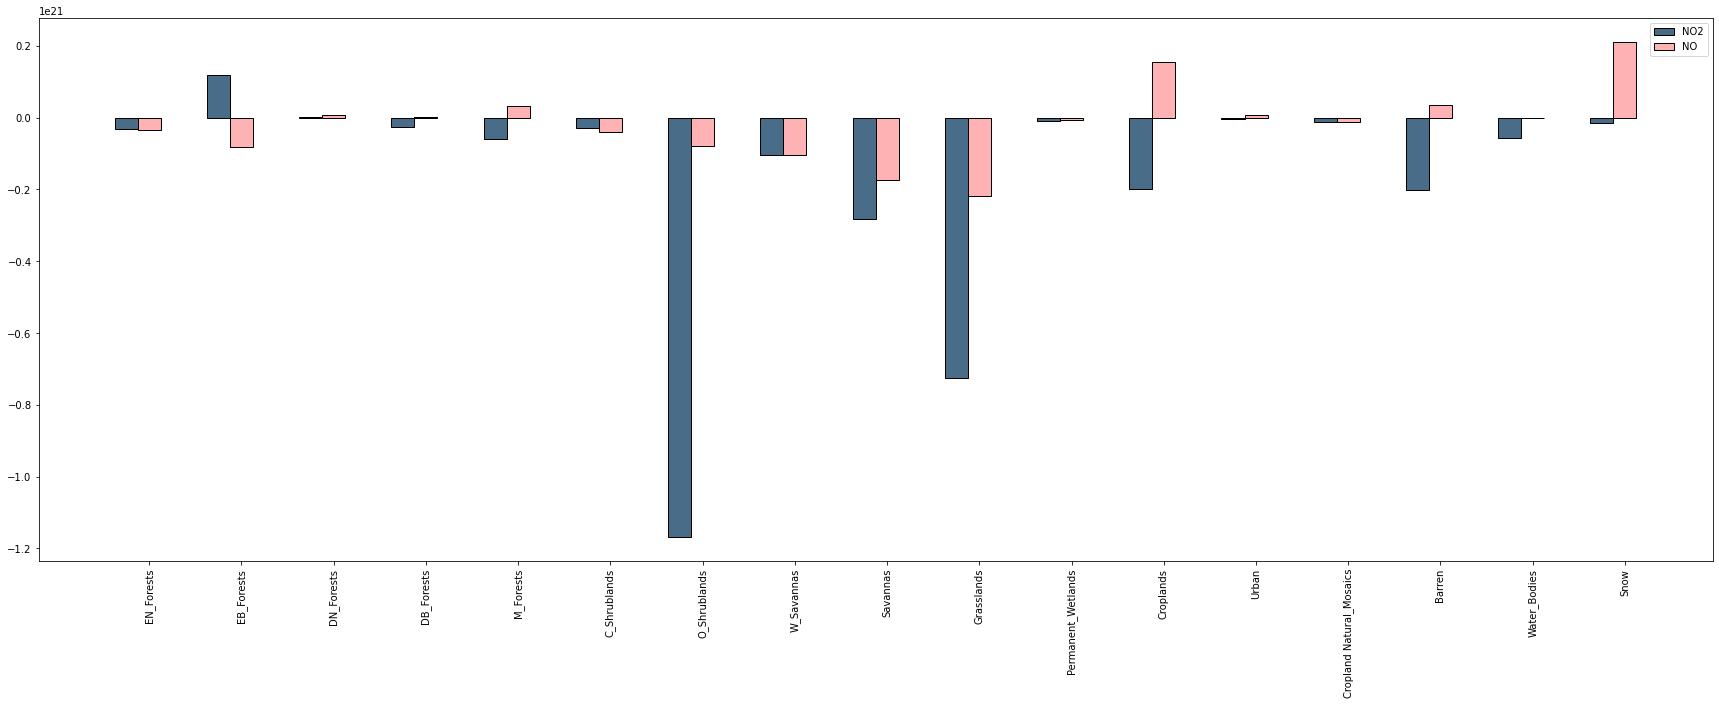

In [43]:
#蓝色nochange RF，粉色change RF
xticks = np.arange(17)
add=[a_transf[:,i].sum()-a_transf[i,i] for i in range(18) if i!=14]
sub=[a_transf[i,:].sum()-a_transf[i,i] for i in range(18) if i!=14]
noc=[a_transf[i,i] for i in range(18) if i!=14]
fig, ax = plt.subplots(figsize=(30,10))
ax.bar(xticks , noc,width=0.25,label='NO2',color='#496C88',edgecolor='black',zorder=5)
ax.bar(xticks+0.25, np.array(add)+np.array(sub),width=0.25,label='NO',color='#FEB2B4',edgecolor='black',zorder=5)
ax.legend()
ax.set_xticks(xticks + 0.25)
ax.set_xticklabels(ll)
plt.xticks(rotation=90)
plt.show()

# 验证

### 500m分辨率年合成

In [1]:
from tool import *
for y in [2001,2020]:
    for m in range(1,13):
        
        print(y,m)
        BS_img=rasterio.open(root_path+f'albedo/{y}_{m}_albedo/{y}_{m}_band5.tif').read(1)
        # print(1)
        BS_img_snowfree=rasterio.open(root_path+f'albedo/{y}_{m}_albedo/{y}_{m}_band11.tif').read(1)
        # print(1)
        count=rasterio.open(root_path+f'albedo/{y}_{m}_albedo/{y}_{m}_band13.tif').read(1)
        # print(1)
        snow_count=rasterio.open(root_path+f'albedo/{y}_{m}_albedo/{y}_{m}_band14.tif').read(1)
        # print(1)
        
        count=count.astype(np.float32)
        count[count==0]=np.nan

        BS=(BS_img*snow_count+BS_img_snowfree*(count-snow_count))/count
        del BS_img,BS_img_snowfree,count,snow_count
        gc.collect()

        tif_save_snowfre(BS,root_path+f'albedo/{y}_{m}_albedo/{y}_{m}_BS.tif',global_trf,p='4326')
for y in [2001,2020]:
    for m in range(1,2):
        print(y,m)
        BS_img=rasterio.open(root_path+f'albedo/{y}_{m}_albedo/{y}_{m}_band6.tif').read(1)
        BS_img_snowfree=rasterio.open(root_path+f'albedo/{y}_{m}_albedo/{y}_{m}_band12.tif').read(1)
        count=rasterio.open(root_path+f'albedo/{y}_{m}_albedo/{y}_{m}_band13.tif').read(1)
        snow_count=rasterio.open(root_path+f'albedo/{y}_{m}_albedo/{y}_{m}_band14.tif').read(1)
        
        count=count.astype(np.float32)
        count[count==0]=np.nan
        
        BS=(BS_img*snow_count+BS_img_snowfree*(count-snow_count))/count
        del BS_img,BS_img_snowfree,count,snow_count
        gc.collect()

        tif_save_snowfre(BS,root_path+f'albedo/{y}_{m}_albedo/{y}_{m}_WS.tif',global_trf,p='4326')

2001 1
2001 2
2001 3
2001 4
2001 5
2001 6
2001 7
2001 8
2001 9
2001 10
2001 11
2001 12
2020 1
2020 2
2020 3
2020 4
2020 5
2020 6
2020 7
2020 8
2020 9
2020 10
2020 11
2020 12


In [1]:
from tool import *
def get_ma(y,m):
    black_nir=get_wb_fraction_data('nbd')
    white_nir=get_wb_fraction_data('ndd')
    black_vis=get_wb_fraction_data('vbd')
    white_vis=get_wb_fraction_data('vdd')
    fn=white_nir[0]/(white_nir[0]+black_nir[0])
    fv=white_vis[0]/(white_vis[0]+black_vis[0])
    f_white=(fn+fv)/2
    f_white_data=f_white.data
    f_white_mask=f_white.mask
    f_white_data[f_white_mask==1]=2
    f_white_data[f_white_mask==1]=2
    # ds=[resample_wb_fraction(f_white_data[i]) for i in range(240)]
    # f_white_resample=np.stack(ds)
    # f_white_resample[f_white_resample==2]=np.nan
    wb=f_white_data[(y-2001)*12+m-1]
    wb_resample=resample_wb_fraction(wb,width=80152,height=40076,resample_alg = gdalconst.GRIORA_NearestNeighbour)
    wb_resample[wb_resample==2]=np.nan
    WS=rasterio.open(root_path+f'albedo/{y}_{m}_albedo/{y}_{m}_WS.tif').read(1)
    BS=rasterio.open(root_path+f'albedo/{y}_{m}_albedo/{y}_{m}_BS.tif').read(1)
    a=((WS*wb_resample+BS*(1-wb_resample))/1000)
    return a

for y in [2001,2020]:
    b=np.zeros((40076,80152)).astype(np.float32)
    for m in range(1,13):
        print(y,m)
        a=get_ma(y,m)
        b+=a
    b=b/12
    tif_save_snowfre(b,root_path+f'albedo/{y}_sw_albedo.tif',global_trf,p='4326')

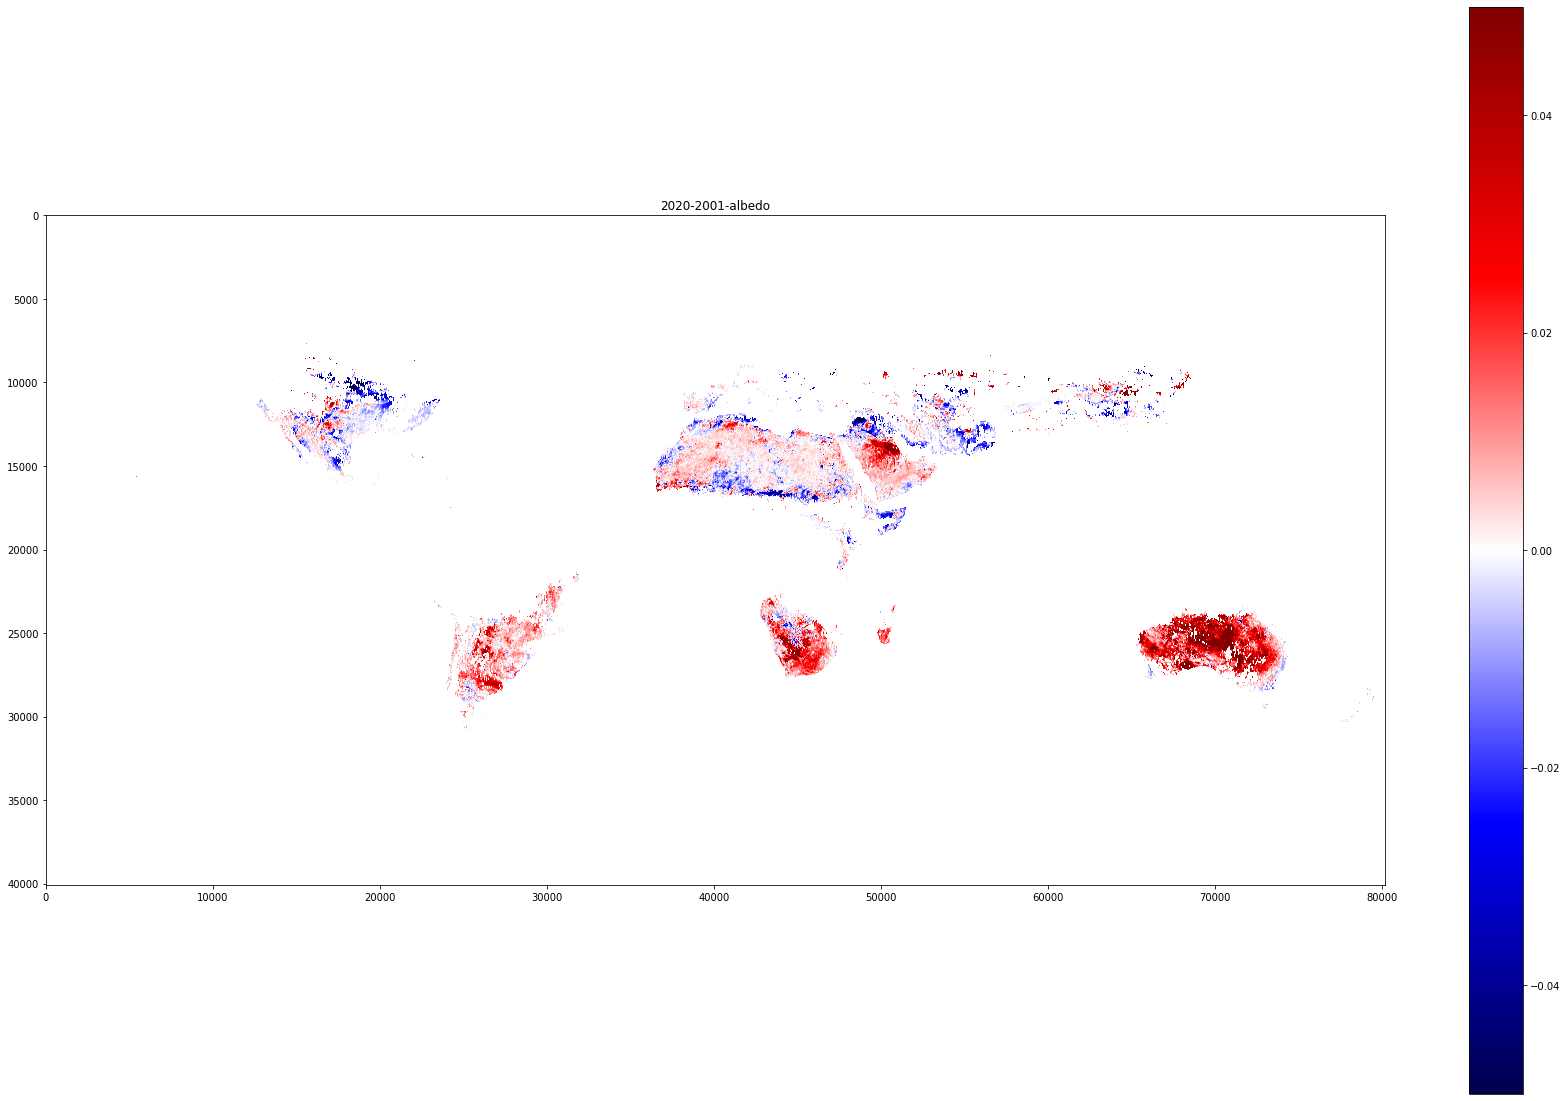

In [4]:
a_2020=rasterio.open(root_path+f'albedo/2020_sw_albedo.tif').read(1)
a_2001=rasterio.open(root_path+f'albedo/2001_sw_albedo.tif').read(1)
dif=a_2020-a_2001
plt.figure(figsize=(30,20))
plt.title(f'2020-2001-albedo')
plt.imshow(dif,vmax=0.05,vmin=-0.05,cmap='seismic')
plt.colorbar()
plt.show()

# 插值精度

In [4]:
from tool import *
aaa={'y':[],'m':[],'lon':[],'lat':[],'type':[]}
landtypes=['landtype'+str(i) for i in range(1,18)]+['snow']
for y in range(2001,2021):
    print(y)
    for m in range(1,13):
        
        f=torch.load(root_path+f'information2/result3_{y}_{m}_all.pth')
        
        a=[]
        for k in f.keys():
            if f[k][1][-1]==f[k][1][-2]:
                a.append(k)
            
        random.shuffle(a)
        a=a[:200]
        aa=[]
        for i in a:
            if abs(int(i.split(',')[0]))<66:
                tt=[landtypes[j] for j in range(18) if f[i][1][j]>2.5]
                for t in tt:
                    aaa['y'].append(y)
                    aaa['m'].append(m)
                    aaa['lon'].append(int(i.split(',')[1]))
                    aaa['lat'].append(int(i.split(',')[0]))
                    aaa['type'].append(t)
aaa_pd=pd.DataFrame.from_dict(aaa)
aaa_pd.to_csv(root_path+'information_val/nan_coords.csv')

2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020


,y,m,lon,lat,type
0,2001,1,31,15,landtype7
1,2001,1,31,15,landtype10
2,2001,1,31,15,landtype16
3,2001,1,125,-21,landtype7
4,2001,1,125,-21,landtype10
...,...,...,...,...,...
213802,2020,12,31,-22,landtype10
213803,2020,12,31,-22,landtype12
213804,2020,12,22,19,landtype7
213805,2020,12,22,19,landtype10


In [6]:
from tool import *
aaa_pd=pd.read_csv(root_path+'information_val/nan_coords.csv')
landtypes=['landtype'+str(i) for i in range(1,18)]+['snow']
bands=['albedo_BSA_vis', 
'albedo_WSA_vis', 
'albedo_BSA_nir', 
'albedo_WSA_nir', 
'albedo_BSA_shortwave',
'albedo_WSA_shortwave']
for m in range(12,13):
    print(m)
    NC=nc.Dataset(root_path+f'information_val/month_{m}.nc','r+')
    for landtype in landtypes:
        for band in bands:
            img=NC.variables[f'{band}-{landtype}'][:]
            # aa_type=[[y-2001,90-i[0],i[1]+180] for i in aaa[y] if i[2]==landtype]
            aa_type=aaa_pd[(aaa_pd.type==landtype) & (aaa_pd.m==m)]
            for ind, row in aa_type.iterrows():
                img[row['y']-2001,90-row['lat'],row['lon']+180]=np.nan
            NC.variables[f'{band}-{landtype}'][:]=img
            NC.sync()
    NC.close()



12


In [10]:
#fill albedo
from tool import *
for month in range(1,13):
    print(month)
    NC=nc.Dataset(root_path+f'information_val/month_{month}_fill.nc','r+')
    for type in landtypes:
        v_fill,dws=fill_albedo(month,type)
        # NC.createVariable(f'DWS-{type}', 'f4', ("time", "latitude", "longitude"))
        # NC.variables[f'DWS-{type}'][:]=dws
        for band_i in range(len(bands)):
            NC.variables[f'{bands[band_i]}-{type}'][:]=v_fill[band_i]
    NC.close()

1
1 landtype1 238 0.06 %
fill value 100.0%
1 landtype2 580 0.2 %
fill value 100.0%
1 landtype3 0 0.0 %
fill value nan%
1 landtype4 569 0.13 %
fill value 100.0%
1 landtype5 457 0.1 %
fill value 100.0%
1 landtype6 358 0.18 %
fill value 100.0%
1 landtype7 816 0.17 %
fill value 100.0%
1 landtype8 761 0.12 %
fill value 100.0%
1 landtype9 1012 0.14 %
fill value 100.0%
1 landtype10 1613 0.16 %
fill value 100.0%
1 landtype11 593 0.08 %
fill value 100.0%
1 landtype12 933 0.21 %
fill value 100.0%
1 landtype13 1026 0.19 %
fill value 100.0%
1 landtype14 437 0.17 %
fill value 100.0%
1 landtype15 0 0.0 %
fill value nan%
1 landtype16 996 0.14 %
fill value 100.0%
1 landtype17 672 0.09 %
fill value 100.0%
1 snow 239 0.02 %
fill value 100.0%
2
2 landtype1 248 0.06 %
fill value 100.0%
2 landtype2 543 0.19 %
fill value 100.0%
2 landtype3 9 0.01 %
fill value 100.0%
2 landtype4 583 0.13 %
fill value 100.0%
2 landtype5 467 0.1 %
fill value 100.0%
2 landtype6 303 0.16 %
fill value 100.0%
2 landtype7 806 0.17 

In [23]:
from tool import *
aaa2=[]
aaa_pd=pd.read_csv(root_path+'information_val/nan_coords.csv')
landtypes=['landtype'+str(i) for i in range(1,18)]+['snow']
bands=['albedo_BSA_vis', 
'albedo_WSA_vis', 
'albedo_BSA_nir', 
'albedo_WSA_nir', 
'albedo_BSA_shortwave',
'albedo_WSA_shortwave']
for m in range(1,13):
    print(m)
    NC=nc.Dataset(root_path+f'information_val/month_{m}_fill.nc','r')
    for landtype in landtypes:
        kk={}
        aa_type=aaa_pd[(aaa_pd.type==landtype) & (aaa_pd.m==m)]
        for band in bands:
            img=NC.variables[f'{band}-{landtype}'][:]
            # aa_type=[[y-2001,90-i[0],i[1]+180] for i in aaa[y] if i[2]==landtype]
            kk[band]=[]
            for ind, row in aa_type.iterrows():
                kk[band].append(img[row['y']-2001,90-row['lat'],row['lon']+180])
            aa_type[f'{band}_pred']=kk[band]
        aaa2.append(aa_type)
    NC.close()
aaa_pd2=pd.concat(aaa2)

1
2
3
4
5
6
7
8
9
10
11
12


In [24]:
from tool import *
aaa2=[]
# aaa_pd=pd.read_csv(root_path+'information_val/nan_coords.csv')
landtypes=['landtype'+str(i) for i in range(1,18)]+['snow']
bands=['albedo_BSA_vis', 
'albedo_WSA_vis', 
'albedo_BSA_nir', 
'albedo_WSA_nir', 
'albedo_BSA_shortwave',
'albedo_WSA_shortwave']


for m in range(1,13):
    print(m)
    NC=nc.Dataset(root_path+f'information_fill/month_{m}.nc','r')
    for landtype in landtypes:
        kk={}
        aa_type=aaa_pd2[(aaa_pd2.type==landtype) & (aaa_pd2.m==m)]
        for band in bands:
            img=NC.variables[f'{band}-{landtype}'][:]
            # aa_type=[[y-2001,90-i[0],i[1]+180] for i in aaa[y] if i[2]==landtype]
            kk[band]=[]
            for ind, row in aa_type.iterrows():
                kk[band].append(img[row['y']-2001,90-row['lat'],row['lon']+180])
            aa_type[f'{band}_gt']=kk[band]
        aaa2.append(aa_type)
    NC.close()
aaa_pd3=pd.concat(aaa2)

1
2
3
4
5
6
7
8
9
10
11
12


In [25]:
aaa_pd3

,Unnamed: 0,y,m,lon,lat,type,albedo_BSA_vis_pred,albedo_WSA_vis_pred,albedo_BSA_nir_pred,albedo_WSA_nir_pred,albedo_BSA_shortwave_pred,albedo_WSA_shortwave_pred,albedo_BSA_vis_gt,albedo_WSA_vis_gt,albedo_BSA_nir_gt,albedo_WSA_nir_gt,albedo_BSA_shortwave_gt,albedo_WSA_shortwave_gt
65,65,2001,1,-110,30,landtype1,27.243711,28.114714,140.163116,144.103729,92.000771,94.353348,25.387096,26.032259,137.903229,141.064514,90.000000,91.935486
209,209,2001,1,-83,33,landtype1,30.106546,30.214226,170.545212,170.844238,108.168999,108.390114,30.915001,31.090000,173.029999,173.490005,109.815002,110.044998
219,219,2001,1,-119,35,landtype1,22.401516,22.388462,116.689545,115.715950,76.543587,76.076378,25.339853,25.365526,124.541565,123.886307,82.623474,82.323959
314,314,2001,1,-63,-26,landtype1,23.549192,30.452765,161.753540,189.127594,98.433853,114.405334,24.500000,29.218750,162.729172,185.395828,99.062500,111.791664
358,358,2001,1,140,37,landtype1,28.338903,27.703484,138.839355,137.746124,91.658882,90.836433,25.204336,24.968292,137.621414,136.868835,90.351494,89.857185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213658,213658,2020,12,-107,48,snow,512.872253,497.766388,441.252594,416.054016,470.052948,450.552460,467.119995,448.359985,358.839996,340.399994,408.320007,389.640015
213679,213679,2020,12,-101,45,snow,653.327209,638.599976,534.588562,512.644592,589.775818,571.787720,633.754089,614.964355,544.493042,518.412903,583.170349,561.059937
213681,213681,2020,12,49,51,snow,634.713623,617.053284,491.616333,461.020538,561.749207,538.599609,740.156067,720.701538,563.594727,521.733582,651.761780,622.901917
213717,213717,2020,12,-9,38,snow,286.657227,281.757233,251.036423,245.135880,260.679901,255.360153,274.976257,269.914001,235.758820,229.966583,247.366669,242.023041


In [27]:
from sklearn.metrics import r2_score

In [30]:
r2_score(np.array(aaa_pd3['albedo_BSA_shortwave_gt'])/1000,np.array(aaa_pd3['albedo_BSA_shortwave_pred'])/1000)

0.9546457585625303

In [32]:
for band in bands:
    r2=r2_score(np.array(aaa_pd3[f'{band}_gt'])/1000,np.array(aaa_pd3[f'{band}_pred'])/1000)
    print(band,r2)

albedo_BSA_vis 0.9617504093925116
albedo_WSA_vis 0.9619040528620466
albedo_BSA_nir 0.9483547182727713
albedo_WSA_nir 0.9468059070722267
albedo_BSA_shortwave 0.9546457585625303
albedo_WSA_shortwave 0.9529353338438105
